In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/review-raw.csv')[['author_id', 'app_id', 'voted_up', 'timestamp', 'review']].copy(deep=True)
df.head()

,author_id,app_id,voted_up,timestamp,review
0,76561197960432447,10,True,1738278781,A legendary tactical shooter that shaped the g...
1,76561198071230926,10,True,1736206418,"The best CS sure, but server browser is the il..."
2,76561198206216352,10,True,1738041574,Some of the best memories of my childhood were...
3,76561198110801124,10,True,1738015332,This game feels so much better than CS2. I kno...
4,76561199813732773,10,True,1737853720,its very fun to play you can make friends out ...


## Mapping user id and app id to indices

In [3]:
user_map = {u: i for i, u in enumerate(df['author_id'].unique())}
item_map = {i: j for j, i in enumerate(df['app_id'].unique())}

df['user_idx'] = np.array([user_map[u] for u in df['author_id']])
df['item_idx'] = np.array([item_map[i] for i in df['app_id']])
df['rating_int'] = df['voted_up'].astype(int)

## Splitting the data

In [4]:
df_train_eval, df_test = train_test_split(df[['user_idx', 'item_idx', 'rating_int']], test_size=0.1, random_state=42)
df_train, df_eval = train_test_split(df_train_eval, test_size=(0.1/0.9), random_state=42)

train_dataset = NCFDataset(df_train)
eval_dataset = NCFDataset(df_eval)
test_dataset = NCFDataset(df_test)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False)

unique_users = df["user_idx"].unique()
unique_items = df["item_idx"].unique()

In [5]:
print(df_train.shape)
print(df_eval.shape)
print(df_test.shape)

(1413153, 3)
(176645, 3)
(176645, 3)


## Train model

In [ ]:
model = NCFRecommender(unique_users, unique_items)
model.fit(train_dataloader, eval_dataloader)

Epoch 1
-------------------------------
loss: 0.768205  [  256/1413153]
loss: 0.747881  [25856/1413153]
loss: 0.729712  [51456/1413153]
loss: 0.757479  [77056/1413153]
loss: 0.734396  [102656/1413153]
loss: 0.697407  [128256/1413153]
loss: 0.693570  [153856/1413153]
loss: 0.660424  [179456/1413153]
loss: 0.690643  [205056/1413153]
loss: 0.660340  [230656/1413153]
loss: 0.634344  [256256/1413153]
loss: 0.628638  [281856/1413153]
loss: 0.642558  [307456/1413153]
loss: 0.636001  [333056/1413153]
loss: 0.637851  [358656/1413153]
loss: 0.594645  [384256/1413153]
loss: 0.598754  [409856/1413153]
loss: 0.576477  [435456/1413153]
loss: 0.574407  [461056/1413153]
loss: 0.589863  [486656/1413153]
loss: 0.557897  [512256/1413153]
loss: 0.558176  [537856/1413153]
loss: 0.552395  [563456/1413153]
loss: 0.554169  [589056/1413153]
loss: 0.535275  [614656/1413153]
loss: 0.560924  [640256/1413153]
loss: 0.558120  [665856/1413153]
loss: 0.562245  [691456/1413153]
loss: 0.515280  [717056/1413153]
loss: 0

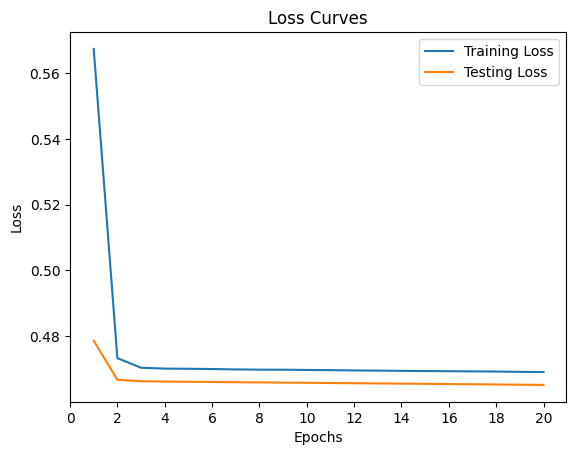

In [ ]:
train_losses = model.train_losses
eval_losses = model.eval_losses
epochs = model.epochs

plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), eval_losses, label="Testing Loss")
plt.xticks(ticks=np.arange(0, epochs + 1, 2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

In [ ]:
def predict(users, items):
    model.model.eval()
    users = torch.tensor(users, dtype=torch.long)
    items = torch.tensor(items, dtype=torch.long)
    with torch.no_grad():
        users = users.to(model.device)
        items = items.to(model.device)
        predictions =model.model(users, items)
    return predictions

predict([0], [0])

tensor([0.7973], device='cuda:0')

In [ ]:
def predict_for_users(users, batch_size=1024):
    """
    Generate predictions for all items for each user
    
    Args:
        model: Trained NCF model
        users: List of user IDs
        all_items: Tensor of all item IDs
        timestamp: Current timestamp or tensor of timestamps (one per user)
        device: Device to run prediction on
        batch_size: Batch size for prediction
        
    Returns:
        Dictionary mapping user IDs to tensors of scores for all items
    """
    model.model.eval()
    predictions = {}
    
    with torch.no_grad():
        # Process each user
        for user_id in users:
            user_tensor = torch.full((len(model.unique_items),), user_id, dtype=torch.long)
            
            all_scores = []
            for i in range(0, len(model.unique_items), batch_size):
                batch_items = model.unique_items[i:i+batch_size]
                batch_users = user_tensor[i:i+batch_size]
                
                # Move to device
                batch_users = batch_users.to(model.device)
                batch_items = batch_items.to(model.device)
                
                # Get predictions
                batch_scores = model.model(batch_users, batch_items)
                all_scores.append(batch_scores.cpu())
            
            # Combine all batches
            user_predictions = torch.cat(all_scores).squeeze()
            predictions[user_id] = user_predictions
            
    return predictions

predictions = predict_for_users([1])

In [ ]:
import heapq
# Generate predictions and prepare ground truth
predictions = {}  # user_id -> ordered list of recommended items
ground_truth = {}  # user_id -> set of relevant items from test set
k = 10
test_unique_users = df_test['user_idx'].unique()

# For each user in test set
for user_idx in test_unique_users:
    relevant_items = set(df_test[df_test['user_idx'] == user_idx]['item_idx'])
    ground_truth[user_idx] = relevant_items
    
    scores = predict_for_users([user_idx])[user_idx].numpy()
    top_k_items = []
    k = 10
    
    for item_id, score in enumerate(scores):
        # For a min-heap, we use negative score to get highest scores
        if len(top_k_items) < k:
            heapq.heappush(top_k_items, (score, item_id))
        elif score > top_k_items[0][0]:
            heapq.heappushpop(top_k_items, (score, item_id))
            
    # Convert heap to sorted list (highest scores first)
    sorted_items = [item_id for score, item_id in sorted(top_k_items, reverse=True)]
    
    predictions[user_idx] = sorted_items

In [ ]:
import json

with open('data/predictions.json', 'w') as f:
    json.dump(predictions, f)
    
with open('data/ground_truth.json', 'w') as f:
    json.dump(ground_truth, f)

In [34]:
def hit_ratio_at_k(predictions, ground_truth, k=10):
    """
    Calculate Hit Ratio@k for recommendations.
    
    Args:
        predictions: Dictionary mapping user IDs to ordered lists of recommended item IDs
        ground_truth: Dictionary mapping user IDs to sets of relevant item IDs
        k: Number of top recommendations to consider
    
    Returns:
        Hit Ratio@k score (between 0 and 1)
    """
    hits = 0
    total_users = len(ground_truth)
    
    for user_idx, true_items in ground_truth.items():
        if user_idx not in predictions:
            print(f"User {user_idx} missing from predictions")
            continue
            
        # Get top-k recommendations for this user
        recommended_items = predictions[user_idx][:k]
        
        # Check if any true items appear in the recommendations
        if any(item in true_items for item in recommended_items):
            print('True items:', true_items)
            print('Recommended items:', recommended_items)
            print('='*50)
            hits += 1

    return hits / total_users if total_users > 0 else 0

In [35]:
hit_ratio_at_k(predictions, ground_truth)

0.0

In [13]:
import numpy as np

def ndcg_at_k(predictions, ground_truth, k=10):
    """
    Calculate NDCG@k for recommendations.
    
    Args:
        predictions: Dictionary mapping user IDs to ordered lists of recommended item IDs
        ground_truth: Dictionary mapping user IDs to sets of relevant item IDs
        k: Number of top recommendations to consider
    
    Returns:
        NDCG@k score (between 0 and 1)
    """
    ndcg_scores = []
    
    for user_id, true_items in ground_truth.items():
        if user_id not in predictions or not true_items:
            continue
            
        # Get top-k recommendations for this user
        recommended_items = predictions[user_id][:k]
        
        # Calculate DCG
        dcg = 0
        for i, item in enumerate(recommended_items):
            if item in true_items:
                # Using binary relevance (1 if relevant, 0 if not)
                # Position i+1 because we start counting from 0
                dcg += 1 / np.log2(i + 2)  # log base 2 of position + 1
        
        # Calculate ideal DCG (IDCG)
        # IDCG is the DCG value if recommendations were perfect
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_items), k)))
        
        # Calculate NDCG
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    
    return sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0

In [36]:
ndcg_at_k(predictions, ground_truth)

0.0

In [37]:
def recall_at_k(predictions, ground_truth, k=10):
    """
    Calculate Recall@k for recommendations.
    
    Args:
        predictions: Dictionary mapping user IDs to ordered lists of recommended item IDs
        ground_truth: Dictionary mapping user IDs to sets of relevant item IDs
        k: Number of top recommendations to consider
    
    Returns:
        Recall@k score (between 0 and 1)
    """
    recalls = []
    
    for user_id, true_items in ground_truth.items():
        if user_id not in predictions or not true_items:
            continue
            
        # Get top-k recommendations for this user
        recommended_items = predictions[user_id][:k]
        
        # Count relevant items in the recommendations
        num_relevant = sum(1 for item in recommended_items if item in true_items)
        
        # Calculate recall for this user
        user_recall = num_relevant / len(true_items)
        recalls.append(user_recall)
    
    return sum(recalls) / len(recalls) if recalls else 0

In [38]:
recall_at_k(predictions, ground_truth)

0.0